In [2]:
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np

#from functions import *

In [3]:
# Door 1
# Timestamp can be ignoreb because there's a constant difference of 40 units

door1 = pd.read_csv("data/data_door1.txt",  sep=";", header=None)
door1 = door1.set_axis(["Timestamp", "x", "y", "z", "pressure"], axis=1, inplace=False)

# Door 2
door2 = pd.read_csv("data/data_door2.txt",  sep=";", header=None)
door2 = door2.set_axis(["Timestamp", "x", "y", "z", "?", "pressure"], axis=1, inplace=False)

# has 5 variables ???

# Test Data (where is from ??)
testdata = pd.read_csv("data/testdata.csv", sep=";", header=None)
testdata = testdata.set_axis(["Timestamp", "x", "y", "z", "pressure"], axis=1, inplace=False)

In [3]:
door1.head()

,Timestamp,x,y,z,pressure
0,2975,-14.460515,0.517131,0.095765,83.465385
1,3015,-12.028084,0.421366,0.076612,83.465782
2,3055,-10.840598,0.344754,0.134071,83.465599
3,3095,-10.227702,0.344754,0.153224,83.465515
4,3134,-9.902101,0.325601,0.114918,83.465507


______________________________________________________________________________________________________________

In [11]:
# Start selecting one variable and segmenting
# DOOR 1 : X

variable = list(door1.x)
print("length: ", len(variable))

length:  6057868


In [12]:
def calculateMedian(i, variable, size):        
    start = max(i - size, 0) 
    end = min(i, len(variable)) 

    calculate_median = variable[start:end]
    calculate_median.sort()
    if(len(calculate_median) > 0): median = calculate_median[len(calculate_median)//2]
    else: median = variable[i]
        
    return median

def rolling_media(i, variable, size, variableMedian):
    median = calculateMedian(i, variable, size)
    variableMedian.append(median)

        
def cummulative_sum(i, variableMedian, gMax, gMin, drift):
        s_i = variableMedian[i] - variableMedian[i-1]
        gMax_i = max(gMax[i-1] + s_i - drift, 0)
        gMin_i = max(gMin[i-1] - s_i - drift, 0)
        gMax.append(gMax_i)
        gMin.append(gMax_i)
        
        compare_old = s_i
        
        return gMax_i, gMin_i

In [16]:
#### DONT RUN !!!!!!!!


### MEDIAN values #####

size = 100                # Size of the median window
variableMedian = list()   # median stored


#### CUSUM values #####

drift = 0.07              # drift: CUSUM parameter
threshold = 0.01          # threshold: CUSUM parameter

alarms = list()           # Points where a movement change is detected
opening = list()          # Points when an upward movement is detected
closing = list()          # Points when an downward movement is detected

s = list([0])             # internal variables for CUSUM
gMax = list([0])
gMin = list([0])


### STEP Detection ####

alarmDetected = False
alarmInterval = 10             # Alarms closer than this will be considerated consecutive
alarmCounter = 0               # Counter of consecutive alarms
change = list()                # Cumulative alarms


closingDetected = False
openingDetected = False
lastClosing = -1               # Index of last closing
lastOpening = -1               # Index of last opening
lastAlarm = -1                 # Index of last alarm


### Slope ponderation ####

slope = list([0])              # Storing slope


for i in range(0, 500000):
    
    ### MEDIAN calculation #####
    # Calculate median of raw data     
    rolling_media(i, variable, size, variableMedian)

    ###### CUSUM intervals #####
    # Detect growing and decreasing tendences on the median,
    # Results in a list of indexes of changes
    if(i != 0):
        
        gMax_i, gMin_i = cummulative_sum(i, variableMedian, gMax, gMin, drift)
        
        alarmDetected = gMax_i > threshold or gMin_i > threshold
        if(alarmDetected): alarms.append(i)
            
        openingDetected = gMax_i > threshold
        if(openingDetected): opening.append(i)

        closingDetected = gMin_i > threshold
        if(closingDetected): closing.append(i)
                
        
    ### Slope ponderation ####
    # Calculate the slope of the median to ponderate with the added value in case 
    # of positive alarm. Helps define the intervals with more precision, solve errors
    # in definition and provides an aproximation of speed
    
    # (fun(i) - fun(j) / (i-j)) # i-j is constant, j = i - 1
    if(i != 0): slope.append(variableMedian[i] - variableMedian[i-1])
        
    
    #### Step Detection #####
    # Apply ponderation an calculate cumulative movement
    
    if(alarmDetected):
        alarmCounter += (1 * slope[i])
        lastAlarm = i
         
    elif(lastAlarm > i - alarmInterval):  # Interval exceded
        alarmCounter += (1 * slope[i])

    else:
        alarmCounter = 0
        
    change.append(alarmCounter)
    


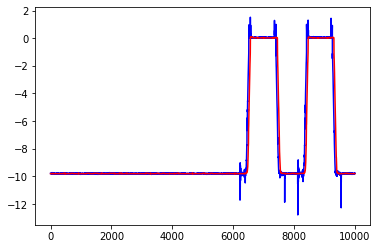

In [18]:
plt.plot(variable[490000:500000], color="blue")
plt.plot(variableMedian[490000:500000], color="red")

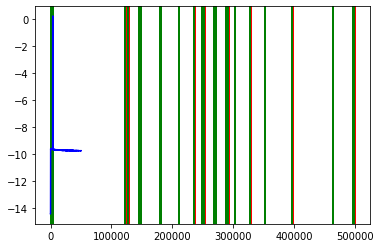

In [19]:
# Alarms detected with median
for i in closing:
    plt.axvline(x=i, color='red', linestyle='-')
for i in opening:
    plt.axvline(x=i, color='green', linestyle='-')

plt.plot(variableMedian[0:50000], color="blue")


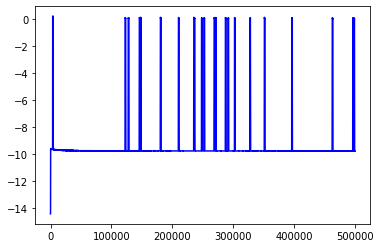

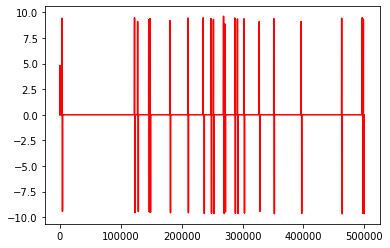

In [20]:
plt.plot(variableMedian[0:500000], color="blue")
plt.show()
plt.plot(change[0:500000], color="red")
plt.show()


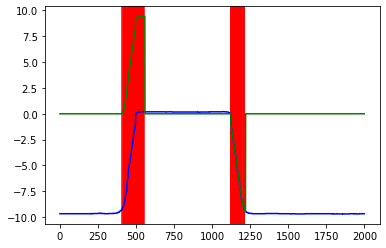

In [15]:
for i in alarms:
    if(i > 3000 and i < 5000):
        plt.axvline(x=i-3000, color='red', linestyle='-')
plt.plot(variableMedian[3000:5000], color="blue")
plt.plot(change[3000:5000], color="green")


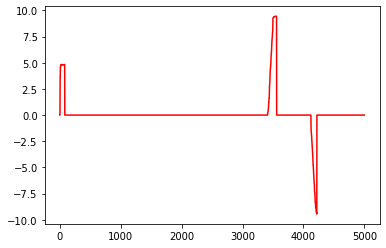

In [16]:
plt.plot(change[0:500000], color="red")

In [6]:
pressure = list(door1.pressure)
y = list(door1.y)